## **Current optimization**
---
#### Overview
- Find the optimal beam current for optical STEM by comparing the SNR at different dwell times. 
- Compare results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import img_as_float, img_as_ubyte
from skimage.util import crop
from skimage import exposure
import tifffile as tf
import pandas as pd
import re
import seaborn as sns
import altair as alt
from tqdm.notebook import tqdm
#from resolution import RES_JOY

In [2]:
# Local imports
import sys
# Add code directory to path
code_dir = '../code/'
if code_dir not in sys.path:
    sys.path.insert(1, code_dir)
import ssnr

In [3]:
%config Completer.use_jedi = False
pd.set_option("display.max_rows", None)

## 1. Load all image data
---

In [4]:
# Find directory
DATA_dir = Path("../data/5_Current-SNR-relation")

# Select files and initialize DataFrame with image locations
df_im = pd.DataFrame({'FilePos': list(DATA_dir.glob('0*/*.tif'))})

# Build up DataFrame
df_im['Current'] =  df_im['FilePos'].apply(lambda x: x.parents[0].name.split('nA')[0])#.split('_')[1])
df_im['Dwell'] =  df_im['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_im['Dwell'] = df_im['Dwell'].astype(float)
df_im['Current'] = df_im['Current'].astype(float)
df_im = df_im.sort_values(['Dwell'], ascending=[True])

# Preview
df_im.sample(5)

,FilePos,Current,Dwell
110,..\data\5_Current-SNR-relation\0.2nA\OSTEM_4kV...,0.20,5000.0
77,..\data\5_Current-SNR-relation\0.1nA\OSTEM_4kV...,0.10,500.0
32,..\data\5_Current-SNR-relation\0.05nA\OSTEM_4k...,0.05,5000.0
133,..\data\5_Current-SNR-relation\0.4nA\OSTEM_4kV...,0.40,100.0
15,..\data\5_Current-SNR-relation\0.05nA\OSTEM_4k...,0.05,100.0


## 2. Perform SSNR measurements
---

In [5]:
# Initialize DataFrame for SNR
df_snr = pd.DataFrame(columns=['Current','Dwell time', 'SSNR', 'SNR_Joy'])

# Loop through bioimages
for i, row in tqdm(df_im.iterrows(), total=len(df_im)):

    # Load and crop images
    image = img_as_float(tf.imread(row['FilePos'].as_posix()))
    cropped = image[0:920,::]
        
    # Compute SNR from SSNR
    images = ssnr.split_image_rows(image) # Split into rows to avoid streaking effect
    snr = ssnr.SSNR_full(images)
    
    # Compute SNR from Joy 
    snr_joy = ssnr.SNR_JOY(cropped)

    # Populate DataFrame
    df_snr.loc[i, 'Current'] = row['Current']
    df_snr.loc[i, 'Dwell'] = row['Dwell']
    df_snr.loc[i, 'SSNR'] = snr
    df_snr.loc[i, 'SNR_Joy'] = snr_joy

# Preview
df_snr = df_snr.infer_objects()
df_snr.groupby('Current')\
      .apply(lambda x: x[::len(df_snr)//10])

  0%|          | 0/199 [00:00<?, ?it/s]

Current  Dwell time      SSNR   SNR_Joy    Dwell
Current                                                      
0.05    15      0.05         NaN  0.294714  0.101183    100.0
        40      0.05         NaN  0.438426  0.149521    500.0
        1       0.05         NaN  3.184279  1.257223  10000.0
0.10    51      0.10         NaN  0.365549  0.130441    100.0
        78      0.10         NaN  0.423701  0.157891    500.0
        42      0.10         NaN  3.889488  0.870547  10000.0
0.20    90      0.20         NaN  0.480026  0.144981    100.0
        117     0.20         NaN  0.696901  0.214308    500.0
        81      0.20         NaN  4.052983  1.481160  10000.0
0.40    134     0.40         NaN  0.788378  0.200078    100.0
        158     0.40         NaN  0.968602  0.207262    500.0
        123     0.40         NaN  5.246964  1.244828  10000.0
0.80    170     0.80         NaN  0.853189  0.138647    100.0
        166     0.80         NaN  1.536511  0.262828   1000.0
        160     0.80         NaN  4.703649  1.320619  10000.0

In [17]:
source = df_snr[df_snr['Dwell'] > 300]

In [18]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from matplotlib import cycler
import matplotlib as mpl

## 3. Plot results
---

In [19]:
# Group by respective current and dwell, then calculat mean SSNR, reset index to dwell time. 
df_current_mean = source.groupby(by=['Current','Dwell']).apply(lambda x: x.mean())\
                        .drop(['Dwell','Current'], axis=1).reset_index(level='Dwell')
df_current_std = source.groupby(by=['Current','Dwell']).apply(lambda x: x.std())\
                        .drop(['Dwell','Current'], axis=1).reset_index(level='Dwell')
df_dwell_mean = source.groupby(by=['Dwell','Current']).apply(lambda x: x.mean())\
                        .drop(['Dwell'], axis=1)#.reset_index(level='Current (nA)')
df_dwell_std = source.groupby(by=['Dwell','Current']).apply(lambda x: x.std())\
                        .drop(['Dwell'], axis=1)#.reset_index(level='Current (nA)')

### Plot SSNR vs dwell time for different currents

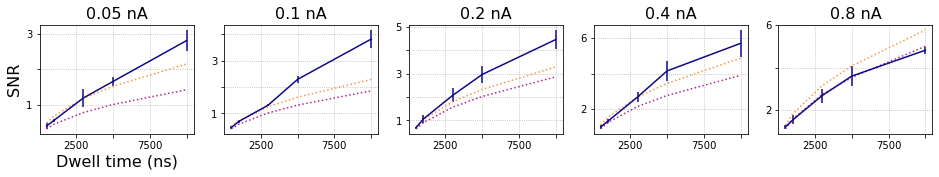

In [55]:
# Plot SSNR vs dwell time for different currents
fontsize = 16

# Colour
cmap = plt.get_cmap('plasma')
mpl.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1.5, len(source['Current'].unique()))))

# Make figure (Dwell time)
nrows = 1
ncols = source['Current'].unique().size 
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=False,
                         figsize=(3.2*ncols, 2*nrows)) # 4.15, 2.5

axmap = {k: v for k, v in zip(df_current_mean.index.unique(), axes.T)}

# Iterate through image subssets by coating:
for (current, current_mean), (current2, current_std) in zip(df_current_mean.groupby(by=['Current']), 
                                                           df_current_std.groupby(by=['Current'])):
    
    ax = axmap[current2]
    ax.errorbar(current_mean['Dwell'], current_mean['SSNR'], current_std['SSNR'])

    # Plot lower bound based on highest SNR
    ax.plot(current_mean['Dwell'], (current_mean['SSNR'].iloc[0] - 1*current_std['SSNR'].iloc[0]) \
            * np.array([np.sqrt(1), np.sqrt(2), np.sqrt(6), np.sqrt(10), np.sqrt(20)]), linestyle='dotted')
    
    # Plot upper bound based on highest SNR
    ax.plot(current_mean['Dwell'], (current_mean['SSNR'].iloc[0] + 1*current_std['SSNR'].iloc[0]) \
            * np.array([np.sqrt(1), np.sqrt(2), np.sqrt(6), np.sqrt(10), np.sqrt(20)]), linestyle='dotted')
    
    ax.set_title(f"{current} nA", fontsize=fontsize)
    ax.grid(which='both', ls=':') 
    
    if current == 0.05:
        ax.set_ylabel('SNR', fontsize=fontsize)
        ax.set_xlabel('Dwell time (ns)', fontsize=fontsize)
        # ax.legend(['expected lower SNR', 'expected upper SNR', 'measured SSNR'], fontsize=fontsize-2, 
        #           loc='upper left', ncol=3, bbox_to_anchor=(1.4, 1.6))
        
    # Tidy up axes
    for label in ax.yaxis.get_majorticklabels()[0::2]:
        label.set_visible(False) 

    for label in ax.xaxis.get_majorticklabels()[0::2]:
        label.set_visible(False)
    
    
plt.savefig('Fig_saturation_dwell', dpi=300, bbox_inches='tight')

### Plot SSNR vs current for different dwells

In [53]:
source = df_snr[df_snr['Dwell'] > 300]

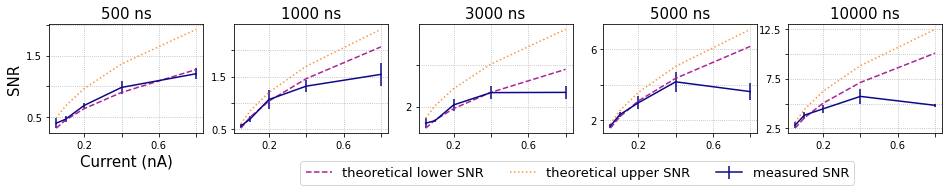

In [54]:
fontsize = 15

# Make figure (Dwell time)
nrows = 1
ncols = source['Dwell'].unique().size 
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=False,
                         figsize=(3.2*ncols, 2*nrows))
#plt.subplots_adjust(hspace=0.1)
#plt.subplots_adjust(wspace=0.1)
axmap = {k: v for k, v in zip(source['Dwell'].unique(), axes.T)}

# Iterate through image subssets by coating:
for (dwell, dwell_mean), (dwell, dwell_std) in zip(df_dwell_mean.groupby(by=['Dwell']), 
                                                           df_dwell_std.groupby(by=['Dwell'])):
    
    ax = axmap[dwell]
    ax.errorbar(dwell_mean['Current'], dwell_mean['SSNR'], dwell_std['SSNR'])
    ax.plot(dwell_mean['Current'], (dwell_mean['SSNR'].iloc[0] - 1*dwell_std['SSNR'].iloc[0]) \
            * np.array([1, np.sqrt(2), np.sqrt(4), np.sqrt(8), np.sqrt(16)]), linestyle='dashed')
    ax.plot(dwell_mean['Current'], (dwell_mean['SSNR'].iloc[0] + 1*dwell_std['SSNR'].iloc[0]) \
            * np.array([1, np.sqrt(2), np.sqrt(4), np.sqrt(8), np.sqrt(16)]), linestyle='dotted')
    
    ax.set_title(f"{int(dwell)} ns", fontsize=fontsize)
    ax.grid(which='both', ls=':') 
    
    if dwell == 500:
        ax.set_ylabel('SNR', fontsize=fontsize)
        ax.set_xlabel('Current (nA)', fontsize=fontsize)
        ax.legend(['theoretical lower SNR', 'theoretical upper SNR', 'measured SNR'], fontsize=fontsize-2, 
                  loc='upper left', ncol=3, bbox_to_anchor=(1.59, -0.2))
    
    # Tidy up axes
    for label in ax.yaxis.get_majorticklabels()[0::2]:
        label.set_visible(False) 

    for label in ax.xaxis.get_majorticklabels()[0::2]:
        label.set_visible(False)
    
plt.savefig('Fig_saturation_current', dpi=300, bbox_inches='tight')

### Plot SNR from SSNR

In [12]:
# Data source for plot
filter_snr = df_snr.loc[df_snr['Dwell time (ns)'] > 1000].copy()
source = filter_snr.loc[filter_snr['SSNR'] > 0.001].copy()
# source = df_snr.copy()
scheme = 'category10'

chart = alt.Chart().encode(
    x=alt.X('Dwell time (ns)',
            axis=alt.Axis(title='Dwell time (ns)')),
    y=alt.Y('SSNR',
            aggregate='mean',
            scale=alt.Scale(domain=[0.5, 5], type='log')),
    color=alt.Color('Current (nA):N',
                    scale=alt.Scale(scheme=scheme),
                    )
).properties(width=600,
             height=300)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart().mark_errorbar(extent='stdev').encode(
    x=alt.X('Dwell time (ns)'),
    y=alt.Y('SSNR'),
    color=alt.Color('Current (nA):N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).configure_axis(
    labelFontSize=25,
    titleFontSize=20
).configure_legend(labelLimit=0, 
                   titleFontSize=15,
                   labelFontSize=15,
                   orient='bottom')


KeyError: 'Dwell time (ns)'

In [ ]:
# Data source for plot
filter_snr = df_snr.loc[df_snr['Dwell time (ns)'] > 1000].copy()
source = filter_snr.loc[filter_snr['SSNR'] > 0.001].copy()
# source = df_snr.copy()
scheme = 'category10'

chart = alt.Chart().encode(
    x=alt.X('Current (nA)',
            axis=alt.Axis(title='Current (nA)')),
    y=alt.Y('SSNR',
            aggregate='mean',
            scale=alt.Scale(domain=[0.5, 5], type='log')),
    color=alt.Color('Dwell time (ns):N',
                    scale=alt.Scale(scheme=scheme),
                    )
).properties(width=600,
             height=300)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart().mark_errorbar(extent='stdev').encode(
    x=alt.X('Current (nA)'),
    y=alt.Y('SSNR'),
    color=alt.Color('Dwell time (ns):N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).configure_axis(
    labelFontSize=25,
    titleFontSize=20
).configure_legend(labelLimit=0, 
                   titleFontSize=15,
                   labelFontSize=15,
                   orient='bottom')

### Plot percentage increase of SNR for dwell time and current

### Plot SNR from Joy, 2002

In [102]:
# SNR Joy

# Data source for plot
filter_snr = df_snr.loc[df_snr['DWELL TIME (ns)'] > 1000].copy()
source = filter_snr.loc[filter_snr['SNR (Joy)'] > 0.001].copy()
# source = df_snr.copy()
scheme = 'category10'

chart = alt.Chart().encode(
    x=alt.X('Current (nA)',
            axis=alt.Axis(title='Current (nA)')),
    y=alt.Y('SNR (Joy)',
            aggregate='mean',
            scale=alt.Scale(domain=[0.1, 10], type='log')),
    color=alt.Color('DWELL TIME (ns):N',
                    scale=alt.Scale(scheme=scheme),
                    )
).properties(width=500,
             height=300)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart().mark_errorbar(extent='stdev').encode(
    x=alt.X('Current (nA)'),
    y=alt.Y('SNR (Joy)'),
    color=alt.Color('DWELL TIME (ns):N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).configure_axis(
    labelFontSize=25,
    titleFontSize=20
).configure_legend(labelLimit=0, 
                   titleFontSize=15,
                   labelFontSize=15,
                   orient='bottom')


KeyError: 'DWELL TIME (ns)'

## 5. Plot images with varying current
---

In [38]:
# Find directory
DATA_dir = Path("../data/5_Current-SNR-relation/Qualitative/Current")

# Select files and initialize DataFrame with image locations
df_im2 = pd.DataFrame({'FilePos': list(DATA_dir.glob('*.tif'))})

# Build up DataFrame
df_im2['Current (nA)'] =  df_im2['FilePos'].apply(lambda x: x.name.split('_')[2].split('nA')[0])
df_im2['DWELL TIME (ns)'] =  df_im2['FilePos'].apply(lambda x: x.name.split('_')[3].split('ns')[0])

# List values in ascending order
df_im2['Current (nA)'] = df_im2['Current (nA)'].astype(float)
df_im2.sort_values(['Current (nA)'], ascending=[True], inplace=True)

# Preview
df_im2

,FilePos,Current (nA),DWELL TIME (ns)
0,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.05,10000
1,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.10,10000
2,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.20,10000
3,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.40,10000
4,..\data\5_Current-SNR-relation\Qualitative\Cur...,0.80,10000


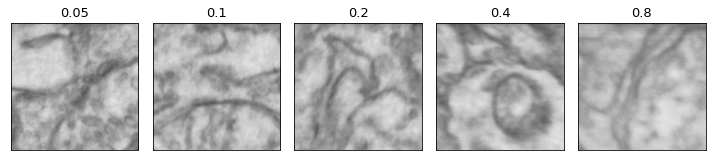

In [39]:
source = df_im2

# Make figure (Dwell time)
nrows = 1
ncols = df_im2['Current (nA)'].unique().size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=True,
                         figsize=(2*ncols, 2.5*nrows))
axmap = {k: v for k, v in zip(source.index, axes)}
plt.subplots_adjust(hspace=0.06,
                    wspace=0.06)

for i, row in source.iterrows():
    im = img_as_float(tf.imread(row['FilePos'].as_posix()))
    cropped = im[:920,:920]
    axmap[i].imshow(cropped, cmap='Greys_r')
    title = f"{row['Current (nA)']}"
    axmap[i].get_xaxis().set_visible(False)
    axmap[i].set_yticks([], [])
        
    # Axis aesthetics
    axmap[i].set_title(title, fontsize=13)
plt.tight_layout()
plt.savefig('current_comparison', dpi=300)

In [ ]:
## 6. Plot images with varying dwell time
---

In [12]:
# Find directory
DATA_dir = Path("../data/Current_Optimization/Qualitative/Dwell")

# Select files and initialize DataFrame with image locations
df_im2 = pd.DataFrame({'FilePos': list(DATA_dir.glob('*.tif'))})

# Build up DataFrame
df_im2['Dwell'] =  df_im2['FilePos'].apply(lambda x: x.name.split('_')[2].split('ns')[0])

# List values in ascending order
df_im2['Current'] = 0.8 # nA
df_im2['Dwell'] = df_im2['Dwell'].astype(float)
df_im2.sort_values(['Dwell'], ascending=[True], inplace=True)

# Preview
df_im2

,FilePos,Dwell,Current
2,..\data\Current_Optimization\Qualitative\Dwell...,100.0,0.8
4,..\data\Current_Optimization\Qualitative\Dwell...,300.0,0.8
1,..\data\Current_Optimization\Qualitative\Dwell...,1000.0,0.8
3,..\data\Current_Optimization\Qualitative\Dwell...,3000.0,0.8
0,..\data\Current_Optimization\Qualitative\Dwell...,10000.0,0.8


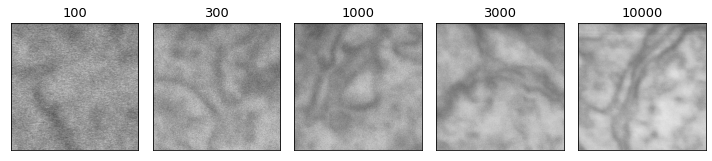

In [14]:
source = df_im2

# Make figure (Dwell time)
nrows = 1
ncols = df_im2['Dwell'].unique().size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         sharex=False, sharey=True,
                         figsize=(2*ncols, 2.5*nrows))
axmap = {k: v for k, v in zip(source.index, axes)}
plt.subplots_adjust(hspace=0.06,
                    wspace=0.06)

for i, row in source.iterrows():
    im = img_as_float(tf.imread(row['FilePos'].as_posix()))
    cropped = im[:920,:920]
    axmap[i].imshow(cropped, cmap='Greys_r')
    title = f"{int(row['Dwell'])}"
    axmap[i].get_xaxis().set_visible(False)
    axmap[i].set_yticks([], [])
        
    # Axis aesthetics
    axmap[i].set_title(title, fontsize=13)
plt.tight_layout()
plt.savefig('dwell_comparison', dpi=300)